In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import ndarray, float32
from sklearn.metrics import confusion_matrix, accuracy_score

# Part A

## 1 Activation and Loss Functions

In [2]:
# loss functions
class MeanSquaredError:
    def __str__(self) -> str:
        return "mse"
    
    @staticmethod
    def __call__(y, y_pred):
        return np.sum((y - y_pred)**2) / len(y)
    
    @staticmethod
    def diff(y, y_pred):
        return y_pred - y

class BinaryCrossEntropy:
    @staticmethod
    def __str__() -> str:
        return "binary cross entropy"
    
    @staticmethod
    def __call__(y, y_pred):
        epsilon = 1e-10
        loss = -np.mean(y * np.log(y_pred + epsilon) + (1 - y) * np.log(1 - y_pred + epsilon))
        return loss

    @staticmethod
    def diff(y, y_pred):
        epsilon = 1e-10
        return (y_pred - y) / (y_pred * (1 - y_pred) + epsilon)
    

# activation functions
class Sigmoid:
    @staticmethod
    def __str__() -> str:
        return "sigmoid"
    
    @staticmethod
    def __call__(x):
        return np.divide(1, np.add(1, np.exp(-x)))
    
    @staticmethod
    def diff(x):
        return Sigmoid.__call__(x) * (1 - Sigmoid.__call__(x))

class ReLU:
    def __str__(self) -> str:
        return "relu"
    
    @staticmethod
    def __call__(x):
        return np.max(0, x)

    @staticmethod
    def diff(x):
        return 1 if x>0 else 0

## 2-3-4
Rest of Part A is implemented in the section below. They have been documented and labeled properly.

In [3]:
class Layer():
    "Class representing the weights and biases of a layer of the MLP using numpy"
    def __init__(self, shape:tuple[int], activation, parameters=None) -> None:
        """MLP Layer contructor
        
        Args:
            shape `<tuple[int]>`: shape of the weights/biases
        """
        self.shape = shape
        self.activation = activation
        self.input = []
        self.output = []
        self.net = []
        if parameters == None:
            self.weights:ndarray[float32] = np.random.randn(shape[0], shape[1])
            self.biases:ndarray[float32] = np.random.randn(1, shape[0])
        else:
            self.weights:ndarray[float32] = np.ones((shape[0], shape[1])) * parameters
            self.biases:ndarray[float32] = np.ones((1, shape[0])) * parameters
        # self.weights:ndarray[float32] = np.zeros((shape[0], shape[1]))
        # self.biases:ndarray[float32] = np.zeros((1, shape[0]))

    def __str__(self) -> str:
        return str(self.shape) + str(self.activation)

    def compute(self, x:ndarray[float32]) -> ndarray[float32]:
        """Calculating `wx + b`
        
        Args:
            x `<ndarray[float32]>`: input data
        """
        self.input = x
        self.net = np.dot(self.input, self.weights.T) + self.biases
        self.output = self.activation(self.net)

In [4]:
class MLP():
    """Class representing an MLP with the preconfiguration from the assignment."""
    def __init__(self, layers:ndarray[tuple[float32, any]], loss, learning_rate:float32, parameters=None) -> None:
        """Building an MLP with the given layer/neuron config.
        
        Args:
        - layers `<ndarray[tuple[float32]]>`: array representing the neurons of each layer.
        - loss: the loss function
        - learning_rate: the learning rate for the MLP for the backprop algorithm.
        - parameters <OPTIONAL>: can be used to set parameter init values if desired.
        """
        
        self.layers = [Layer((layers[i+1][0], layers[i][0]), activation=layers[i+1][1], parameters=parameters) for i in range(len(layers)-1)]
        self.loss = loss
        self.learning_rate = learning_rate

    def __str__(self) -> str:
        return str([str(l) for l in self.layers])

    def feed_forward(self, x:ndarray[float32]):
        """One cycle of feed forward.
        
        Args:
            x `<ndarray[float32]>: One batch of training data.
            
        Returns:
            y_pred `<float32>`: Predicted y value.
        """

        self.layers[0].compute(x.reshape((1,len(x))))
        for i in range(1, len(self.layers)):
            self.layers[i].compute(self.layers[i-1].output)
        return self.layers[-1].output

    def back_propagation(self, y, y_pred) -> None:
        """One pass of back propagation.
        
        Args:
        - y `<ndarray[float32]>`: true value. either (0,1) or (1,0).
        - y_pred `<ndarray[float32]>`: predicted value. either (0,1) or (1,0).
        """

        # print(y, y_pred, y - y_pred, self.loss(y, y_pred), self.loss.diff(y, y_pred))
        delta = self.loss.diff(y, y_pred) * self.layers[-1].activation.diff(self.layers[-1].net)
        d_w = np.matmul(delta.T, self.layers[-1].input)
        d_b = delta

        self.layers[-1].weights -= self.learning_rate * d_w
        self.layers[-1].biases -= self.learning_rate * d_b

        last_delta = delta
        for i in range(len(self.layers)-2, -1, -1):
            delta = np.matmul(last_delta, self.layers[i+1].weights) * self.layers[i].activation.diff(self.layers[i].net)
            d_w = np.matmul(delta.T, self.layers[i].input)
            d_b = delta

            self.layers[i].weights -= self.learning_rate * d_w
            self.layers[i].biases -= self.learning_rate * d_b
            last_delta = delta

In [5]:
def minmax_normalization(df:pd.DataFrame):
    df["X_0"] = (df["X_0"] - min(df["X_0"])) / (max(df["X_0"]) - min(df["X_0"]))
    df["X_1"] = (df["X_1"] - min(df["X_1"])) / (max(df["X_1"]) - min(df["X_1"]))
    return df

## Training

In [6]:
# load the data
training_data:pd.DataFrame = pd.read_excel("THA3train.xlsx")
validation_data:pd.DataFrame = pd.read_excel("THA3validate.xlsx")

# normalize data
training_data = minmax_normalization(training_data)
validation_data = minmax_normalization(validation_data)

# hyperparameter optimization
layers = np.array([
    (2, Sigmoid()), 
    (10, Sigmoid()), 
    (10, Sigmoid()), 
    (1, Sigmoid()),
])
loss=BinaryCrossEntropy()
learning_rate = 0.1
num_epochs = 100
np.random.seed(seed=42)

# init MLP
mlp = MLP(layers=layers, loss=loss, learning_rate=learning_rate)
training_predictions:ndarray = np.zeros((len(training_data["y"]), 1))
training_loss:ndarray = np.zeros(num_epochs)
validation_predictions:ndarray = np.zeros((len(validation_data["y"]), 1))
validation_loss:ndarray = np.zeros(num_epochs)

In [7]:
"""Training and Validation"""
for i in range(num_epochs):
    # training
    for ind in training_data.index:
        # input processing
        inp = np.array([training_data["X_0"][ind], training_data["X_1"][ind]])
        y = np.array(training_data["y"][ind])

        # feed forward
        training_predictions[ind,:] = mlp.feed_forward(inp)

        # back propagation
        mlp.back_propagation(y, training_predictions[ind,:])
    training_loss[i] = mlp.loss(np.array(training_data["y"]), training_predictions)

    # validation
    for ind in validation_data.index:
        # input processing
        inp = np.array([validation_data["X_0"][ind], validation_data["X_1"][ind]])
        y = np.array(validation_data["y"][ind])

        # feed forward
        validation_predictions[ind,:] = mlp.feed_forward(inp)
        validation_predictions[ind,:] = [1 if prob > 0.5 else 0 for prob in validation_predictions[ind,:]]
    validation_loss[i] = mlp.loss(np.array(validation_data["y"]), validation_predictions)

accuracy: 0.975609756097561
confusion matrix: [[40  1]
 [ 1 40]]


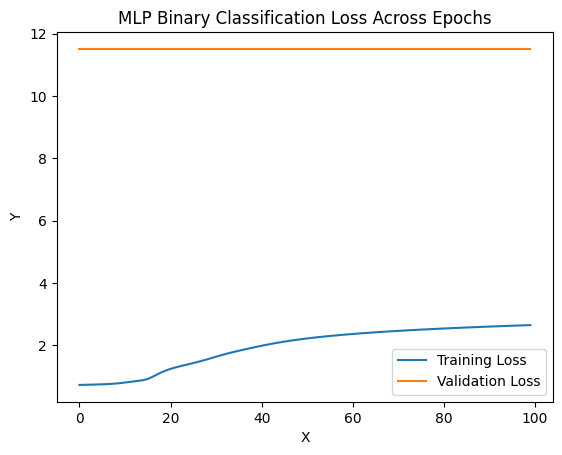

In [8]:
"""Statistics"""

confu_mat = confusion_matrix(validation_data["y"], validation_predictions)
accuracy = accuracy_score(validation_data["y"], validation_predictions)
print("accuracy:", accuracy)
print("confusion matrix:", confu_mat)

# loss plot
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('MLP Binary Classification Loss Across Epochs')
plt.show()

# Part B

## 1 Parameter Initialization

accuracy: 0.5
confusion matrix: [[ 0 41]
 [ 0 41]]


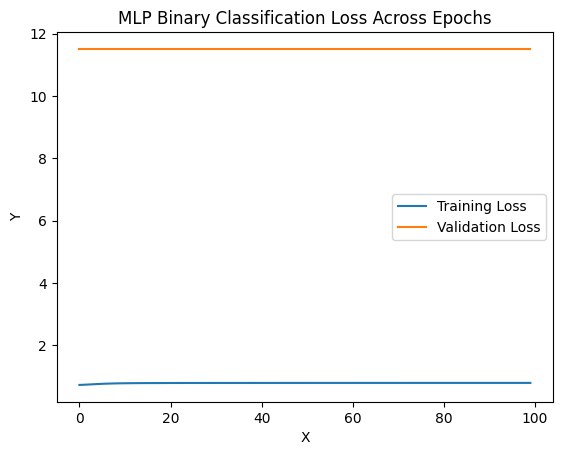

In [9]:
"""part b subproblem 1"""

# load the data
training_data:pd.DataFrame = pd.read_excel("THA3train.xlsx")
validation_data:pd.DataFrame = pd.read_excel("THA3validate.xlsx")

# normalize data
training_data = minmax_normalization(training_data)
validation_data = minmax_normalization(validation_data)

# hyperparameter optimization
layers = np.array([
    (2, Sigmoid()), 
    (10, Sigmoid()), 
    (10, Sigmoid()), 
    (1, Sigmoid()),
])
loss=BinaryCrossEntropy()
learning_rate = 0.1
num_epochs = 100
np.random.seed(seed=42)

# init MLP
mlp = MLP(layers=layers, loss=loss, learning_rate=learning_rate, parameters=0)
training_predictions:ndarray = np.zeros((len(training_data["y"]), 1))
training_loss:ndarray = np.zeros(num_epochs)
validation_predictions:ndarray = np.zeros((len(validation_data["y"]), 1))
validation_loss:ndarray = np.zeros(num_epochs)

"""Training and Validation"""
for i in range(num_epochs):
    # training
    for ind in training_data.index:
        # input processing
        inp = np.array([training_data["X_0"][ind], training_data["X_1"][ind]])
        y = np.array(training_data["y"][ind])

        # feed forward
        training_predictions[ind,:] = mlp.feed_forward(inp)

        # back propagation
        mlp.back_propagation(y, training_predictions[ind,:])
    training_loss[i] = mlp.loss(np.array(training_data["y"]), training_predictions)

    # validation
    for ind in validation_data.index:
        # input processing
        inp = np.array([validation_data["X_0"][ind], validation_data["X_1"][ind]])
        y = np.array(validation_data["y"][ind])

        # feed forward
        validation_predictions[ind,:] = mlp.feed_forward(inp)
        validation_predictions[ind,:] = [1 if prob > 0.5 else 0 for prob in validation_predictions[ind,:]]
    validation_loss[i] = mlp.loss(np.array(validation_data["y"]), validation_predictions)

"""Statistics"""

confu_mat = confusion_matrix(validation_data["y"], validation_predictions)
accuracy = accuracy_score(validation_data["y"], validation_predictions)
print("accuracy:", accuracy)
print("confusion matrix:", confu_mat)

# loss plot
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('MLP Binary Classification Loss Across Epochs')
plt.show()

## 2 Learning rate and parameter initialization

In [10]:
"""Part B subproblem 2"""
# Subproblem 2
lrs = [0.00001, 0.0001, 0.001, 0.01, 0.1]
ws = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
accs = []

# load the data
training_data:pd.DataFrame = pd.read_excel("THA3train.xlsx")
validation_data:pd.DataFrame = pd.read_excel("THA3validate.xlsx")

# normalize data
training_data = minmax_normalization(training_data)
validation_data = minmax_normalization(validation_data)

# hyperparameter optimization
layers = np.array([
    (2, Sigmoid()), 
    (10, Sigmoid()), 
    (10, Sigmoid()), 
    (1, Sigmoid()),
])
loss=BinaryCrossEntropy()
num_epochs = 100
np.random.seed(seed=42)
for i, lr in enumerate(lrs):
    for j, w in enumerate(ws):
        mlp = MLP(layers=layers, loss=loss, learning_rate=lr)
        training_predictions:ndarray = np.zeros((len(training_data["y"]), 1))
        training_loss:ndarray = np.zeros(num_epochs)
        validation_predictions:ndarray = np.zeros((len(validation_data["y"]), 1))
        validation_loss:ndarray = np.zeros(num_epochs)
        for i in range(num_epochs):
            # training
            for ind in training_data.index:
                # input processing
                inp = np.array([training_data["X_0"][ind], training_data["X_1"][ind]])
                y = np.array(training_data["y"][ind])

                # feed forward
                training_predictions[ind,:] = mlp.feed_forward(inp)

                # back propagation
                mlp.back_propagation(y, training_predictions[ind,:])
            training_loss[i] = mlp.loss(np.array(training_data["y"]), training_predictions)

            # validation
            for ind in validation_data.index:
                # input processing
                inp = np.array([validation_data["X_0"][ind], validation_data["X_1"][ind]])
                y = np.array(validation_data["y"][ind])

                # feed forward
                validation_predictions[ind,:] = mlp.feed_forward(inp)
                validation_predictions[ind,:] = [1 if prob > 0.5 else 0 for prob in validation_predictions[ind,:]]
                # print(y, validation_predictions[ind,:])
            validation_loss[i] = mlp.loss(np.array(validation_data["y"]), validation_predictions)
        acc = accuracy_score(validation_data["y"], validation_predictions)
        accs.append([lr, w, acc])

heatmap_df = pd.DataFrame(accs)
heatmap_df

,0,1,2
0,0.00001,0.0,0.500000
1,0.00001,0.1,0.500000
2,0.00001,0.2,0.500000
3,0.00001,0.3,0.500000
4,0.00001,0.4,0.500000
5,0.00001,0.5,0.500000
6,0.00001,0.6,0.500000
7,0.00001,0.7,0.500000
8,0.00001,0.8,0.500000
9,0.00001,0.9,0.500000


In [11]:
heatmap_df
heatmap_mat = np.zeros(shape=(len(lrs), len(ws)))
counter = 0
for i in range(len(lrs)):
    for j in range(len(ws)):
        heatmap_mat[i, j] = heatmap_df[2][counter]
        counter += 1
heatmap_mat

array([[0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       ],
       [0.56097561, 0.53658537, 0.57317073, 0.53658537, 0.46341463,
        0.48780488, 0.47560976, 0.58536585, 0.48780488, 0.52439024,
        0.51219512],
       [0.5       , 0.59756098, 0.48780488, 0.47560976, 0.54878049,
        0.52439024, 0.52439024, 0.56097561, 0.53658537, 0.54878049,
        0.53658537],
       [0.79268293, 0.7804878 , 0.92682927, 0.80487805, 0.80487805,
        0.80487805, 0.92682927, 0.96341463, 0.80487805, 0.96341463,
        0.95121951],
       [0.95121951, 0.97560976, 0.97560976, 0.95121951, 0.97560976,
        0.97560976, 0.96341463, 0.96341463, 0.97560976, 0.95121951,
        0.95121951]])

<Axes: >

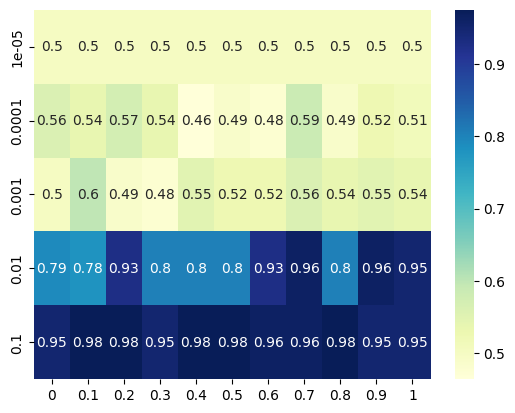

In [12]:
sns.heatmap(heatmap_mat, annot=True, cmap="YlGnBu", 
            xticklabels=ws, yticklabels=lrs)

## 3 Activations

In [13]:
"""part b subproblem 3"""

# load the data
training_data:pd.DataFrame = pd.read_excel("THA3train.xlsx")
validation_data:pd.DataFrame = pd.read_excel("THA3validate.xlsx")

# normalize data
training_data = minmax_normalization(training_data)
validation_data = minmax_normalization(validation_data)

# hyperparameter optimization
layers = np.array([
    (2, Sigmoid()), 
    (10, Sigmoid()), 
    (10, Sigmoid()), 
    (1, Sigmoid()),
])
loss=BinaryCrossEntropy()
learning_rate = 0.1
num_epochs = 100
np.random.seed(seed=42)

# init MLP
mlp = MLP(layers=layers, loss=loss, learning_rate=learning_rate)
training_predictions:ndarray = np.zeros((len(training_data["y"]), 1))
training_loss:ndarray = np.zeros(num_epochs)
validation_predictions:ndarray = np.zeros((len(validation_data["y"]), 1))
validation_loss:ndarray = np.zeros(num_epochs)

"""Training and Validation"""
for i in range(num_epochs):
    if i == 0:
        print("layer outputs before training")
        for j, layer in enumerate(mlp.layers):
            print(f"layer{j}: {layer.output}")
    if i == 1:
        print("layer outputs with one cycle of training")
        for j, layer in enumerate(mlp.layers):
            print(f"layer{j}: {layer.output}")
    if i == num_epochs//2:
        print("layer outputs halfway through training")
        for j, layer in enumerate(mlp.layers):
            print(f"layer{j}: {layer.output}")
    # training
    for ind in training_data.index:
        # input processing
        inp = np.array([training_data["X_0"][ind], training_data["X_1"][ind]])
        y = np.array(training_data["y"][ind])

        # feed forward
        training_predictions[ind,:] = mlp.feed_forward(inp)

        # back propagation
        mlp.back_propagation(y, training_predictions[ind,:])
    training_loss[i] = mlp.loss(np.array(training_data["y"]), training_predictions)

    if i == num_epochs-1:
        print("layer outputs after training")
        for j, layer in enumerate(mlp.layers):
            print(f"layer{j}: {layer.output}")

    # validation
    for ind in validation_data.index:
        # input processing
        inp = np.array([validation_data["X_0"][ind], validation_data["X_1"][ind]])
        y = np.array(validation_data["y"][ind])

        # feed forward
        validation_predictions[ind,:] = mlp.feed_forward(inp)
        validation_predictions[ind,:] = [1 if prob > 0.5 else 0 for prob in validation_predictions[ind,:]]
    validation_loss[i] = mlp.loss(np.array(validation_data["y"]), validation_predictions)

layer outputs before training
layer0: []
layer1: []
layer2: []
layer outputs with one cycle of training
layer0: [[0.85110662 0.65705794 0.47340526 0.46934077 0.35702045 0.46661706
  0.17030827 0.31173594 0.26078904 0.20816269]]
layer1: [[0.07520897 0.41716442 0.57276169 0.56503707 0.59224432 0.87303459
  0.21538507 0.14236651 0.68245313 0.45701822]]
layer2: [[0.62802991]]
layer outputs halfway through training
layer0: [[0.94191435 0.08978676 0.58753821 0.33179168 0.40739087 0.39985977
  0.64199236 0.30888662 0.51842202 0.2862715 ]]
layer1: [[0.0458713  0.93626831 0.48608136 0.93621807 0.86928237 0.98121396
  0.01679355 0.21938511 0.89080939 0.95756981]]
layer2: [[0.99002286]]
layer outputs after training
layer0: [[0.94548684 0.05922767 0.64473719 0.30792461 0.35542722 0.27334929
  0.64081999 0.28606535 0.59554098 0.25124285]]
layer1: [[0.04168513 0.94661746 0.42869722 0.92144505 0.81541685 0.98571535
  0.00681805 0.22903696 0.86669886 0.96320795]]
layer2: [[0.99064863]]


## 4 Hyperparameter optimization
For this section we were unable to plot the Parallel Coordinates Plot to compare the different due to time constraints and implementation difficulties. However, we hope that we can get at least 2 points from this section as we implemented our MLP in an abstract way where it is possible to fine tune: amount of layers, neurons present in each layer, learning rate, parameter init values, loss function, activation functions \textit{per} layer, all out-of-the-box.